# **Actionable Insight for the European Championships**

We have been employed by UEFA (hypothetically - just for simulation purposes) to try to gain actionable insight into two main areas:

1. What statistics help best predict the stage a team will reach when moving on from the groupstage?

2. What statistics help best predict what makes a more entertaining match?

UEFA would like to create the best environment for fans by potential rule changes based on our actionable insight in making the most competitive and entertaining tournament experience for fans across Europe.

We will be analyzing European Championship data (source below) from the 2016 UEFA Euros!

# **Random Decision Forest, Decision Tree, and Linear Regression Classification Modeling for the UEFA Euros**

Below, we will examine data across multiple data sets and compile them into a singular master data sheet. We will refer to the goals above as (1) and (2) in our analysis below.

# **Business Understanding**

For goal (1), to be able to predict the stages that each team will move on to will enable UEFA to better understand what statistics are most indicative of a team to move on and what actions can possibly be taken to reduce exploits on the field and create more competitive games. In our analysis, we will create a variety of statistics (listed below) to create a decision tree to best model and categorize teams by their predicted stage of the tournament.

As for goal (2), to be able to better understand what makes games more competitive and entertaining will better enable UEFA to create environments that fans will pay to watch, and keep coming back for! Again, we will create a variety of statistics (listed below) to create a decision tree to best model and categorize teams by their predicted stage of the tournament. We define entertaining to be a game in which there is more than 1 goal scored and the difference between goals is no more than 1.

# **Goal (1) Statistics**

"rankings" - ESPN rank of each team entering the tournament (pre-tournament ranking) - *indicates expected performance of a team*

"goals" - goals scored by the team in the groupstage - *effectiveness of offense throughout the groupstage*

"goals_against" - goals scored against a team in the groupstage - *defensive effectiveness throughout groupstage*

"matches_won" - matches won in the groupstage - *team efficiency in groupstage*

"passes_75" - number of passes that crossed the 75% mark on the field towards the opponents goal - *measure of opportunity created/offensive efficiency*

"average_gs_goals_per_game" - average goals per game in the groupstage (offensive efficiency) - *another measure of offensive efficiency and team efficiency*

"total_passes" - total passes in the groupstage - *measure of team possession throughout groupstage*

"average_delta_x" - average distance of each pass (net positive or net negative) - *measure of the average movement of the team*

# **Goal (2) Statistics**

"total_passes" - total number of passes during the game - *measure of overall game intensity*

"total_duels" - total number of duels during the game - *measure of overall game intensity*

"forward_passes" - total number of forward passes during the game - *indicator of overall offensive movement in game*

"rank_diff" - rank differential for a given game - *indicator skill level difference between teams*

"average_time_between_passes" - average time between passes during the game - *indicator of intensity of match*

"total_shots" - total number of shots that occured during a game - *indicator of offensive action during game*

"halftime_entertainment_category" - binary classifier to identify whether or not a game was entertaining at the halftime mark - *early indicator as to whether the game will end as entertaining*



# **Data Understanding**

The data used involves multiple json data frames. The following json files were used:

file_path_tournament = '/content/drive/MyDrive/events_European_Championship.json' - contains event information throughout games in the European Championship. An event is considered anytime the ball was touched. Each event has a match identifier, event identifier, and team identifier. We will use this information later on to calculate total duels, shots, and passes that occured for a team or during a match.

file_path_teams = '/content/drive/MyDrive/teams.json' - this file contains information regarding each team in the tournament, giving us an easy way to get from a team identification tag to a team name.

file_path_matches = '/content/drive/MyDrive/matches_European_Championship.json' - this file contains information about matches, including the stage the match occurred in, the information about the match (score, teams that scored, etc.), as well as a match identification tag. We will use this information to determine a teams wins and performance statistics as well as a match's entertainment value based on scoring and event statistics from our events data frame.

The following data transformations below are to create two master sheets, one for each goal. For (1), we created the euro_master_df in which we collect the following data described in the business understanding section above in order to try to create a prediction decision tree model to accurately predict the furthest stage a team will reach. For (2), we also created the matches_classifier_df through various transformations of the data to help create a prediction decision tree model that would accurately predict whether or not a game will be entertaining based on the data described in the above buisiness understanding section.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


#from google.colab import drive
#drive.mount('/content/drive')

#all necessary data imports and reading
file_path_tournament = 'https://raw.githubusercontent.com/baumgardner-leo/baumgardner-leo.github.io/refs/heads/main/events_European_Championship.json'
file_path_teams = 'https://raw.githubusercontent.com/baumgardner-leo/baumgardner-leo.github.io/refs/heads/main/teams.json'
file_path_matches = 'https://raw.githubusercontent.com/baumgardner-leo/baumgardner-leo.github.io/refs/heads/main/matches_European_Championship.json'
file_path_rankings = 'https://raw.githubusercontent.com/baumgardner-leo/baumgardner-leo.github.io/refs/heads/main/playerank.json'
file_path_players = 'https://raw.githubusercontent.com/baumgardner-leo/baumgardner-leo.github.io/refs/heads/main/players.json'
euro_df = pd.read_json(file_path_tournament)
teams_df = pd.read_json(file_path_teams)
matches_df = pd.read_json(file_path_matches)
rankings_df = pd.read_json(file_path_rankings)
players_df = pd.read_json(file_path_players)

#construction of our condensed data set

#mapping id values to team names
grouped_data_teams = teams_df[["officialName", "wyId"]]
map_dict = dict(zip(grouped_data_teams["wyId"], grouped_data_teams["officialName"]))
euro_df["team_name"] = euro_df["teamId"].map(map_dict)

#mapping teams to rankings
ranking_dict = {"France" : 1, "Germany" : 2, "Spain" : 3, "Belgium" : 4, "Italy" : 5, "England" : 6, "Croatia" : 7, "Austria" : 8, "Portugal" : 9, "Poland" : 10, "Slovakia" : 11, "Switzerland" : 12, "Czech Republic" :13, "Wales" : 14, "Iceland":15, "Turkey":16, "Russia":17, "Ukraine":18, "Sweden":19, "Republic of Ireland":20, "Albania":21,"Northern Ireland":22, "Romania":23, "Hungary":24}
euro_df["ranking"] = euro_df["team_name"].map(ranking_dict)

#winner_tag
euro_df["winner_tag"] = [1 if x == "France" else 0 for x in euro_df["team_name"]]

#relevant matches i.e. getting matches that are in the group stage of the tournament
matches_relevant_df = matches_df.iloc[15:51]

# **Creating the euro_master_df for Goal (1)**

In [3]:
#creating a master sheet
euro_master_df = pd.DataFrame()

#initial data points for each team
euro_master_df["team_name"] = pd.DataFrame(euro_df["team_name"].unique())
euro_master_df["team_id"] = pd.DataFrame(euro_df["teamId"].unique())
euro_master_df["rankings"] = euro_master_df["team_name"].map(ranking_dict)
euro_master_df["winner_tag"] = [1 if x == "Portugal" else 0 for x in euro_master_df["team_name"]]


#number of matches won by a team in group stage
winner_dict = {}
for winner_index in matches_relevant_df["winner"]:
  #if the winner index/index of winning team is already in the dictionary, we add a win and if not
  #we add it to the dictionary
  if winner_index in winner_dict:
    winner_dict[winner_index] += 1
  else:
    winner_dict[winner_index] = 1

#anything that did not appear in the above dictionary will get a record of 0 wins
for team in euro_master_df["team_id"]:
  if team not in winner_dict:
    winner_dict[team] = 0

#create a new column in our data set mapping the win number to each team
euro_master_df["matches_won"] = euro_master_df["team_id"].map(winner_dict)

#number of goals per team
goals_dict = {}
for x in matches_relevant_df['teamsData']:
  #add number of goals scored to the value indicated by the team id in each o fthe relevant matches
  for team_id in x.keys():
    if int(team_id) in goals_dict:
      goals_dict[int(team_id)] += int(x[team_id]["score"])
    else:
      goals_dict[int(team_id)] = int(x[team_id]["score"])

for team in euro_master_df["team_id"]:
  if team not in goals_dict:
    goals_dict[team] = 0

#mapping goals in group stage to each team
euro_master_df["goals"] = euro_master_df["team_id"].map(goals_dict)

#goals against each team
against_goals_dict = {}
for x in matches_relevant_df['teamsData']:
  #finding the scores of each team in each game and adding the opposing teams goals scored onto the team
  #that they scored them against
  team_list = list(x.keys())
  team1 = team_list[0]
  team2 = team_list[1]
  if int(team1) in against_goals_dict:
    against_goals_dict[int(team1)] += x[team2]["score"]
  else:
    against_goals_dict[int(team1)] = x[team2]["score"]


  if int(team2) in against_goals_dict:
    against_goals_dict[int(team2)] += x[team1]["score"]
  else:
    against_goals_dict[int(team2)] = x[team1]["score"]

for team in euro_master_df["team_id"]:
  if team not in against_goals_dict:
    against_goals_dict[team] = 0

#mapping the number of goals scored against each team to the team itself
euro_master_df["goals_against"] = euro_master_df["team_id"].map(against_goals_dict)


#number of passes that exceeded the 75% marker
relevent_events_df = euro_df[(euro_df["eventName"] == "Pass") & (euro_df["matchId"].isin(matches_relevant_df["wyId"]))]
passes_dict = {}
for i in range(len(relevent_events_df["positions"])):
  x = relevent_events_df["positions"].iloc[i]
  team = relevent_events_df["teamId"].iloc[i]
  if x[1]["x"] >= 75:
    if team in passes_dict:
      passes_dict[int(team)] += 1
    else:
      passes_dict[int(team)] = 1

#mapping the number of passes that are considered "attacking" to each team, respectively
euro_master_df["passes_75"] = euro_master_df["team_id"].map(passes_dict)

#advancing vs not advancing (0 group stage, 1 round of 16, 2 quarters, 3 semis, 4 final)
advancing_dict = {"France" : 4, "Germany" : 3, "Spain" : 1, "Belgium" : 2, "Italy" : 2, "England" : 1, "Croatia" : 1, "Austria" : 0, "Portugal" : 4, "Poland" : 2, "Slovakia" : 1, "Switzerland" : 1, "Czech Republic" :0, "Wales" : 3, "Iceland":2, "Turkey":0, "Russia":0, "Ukraine":0, "Sweden":0, "Republic of Ireland":1, "Albania":0,"Northern Ireland":1, "Romania":0, "Hungary":1}
euro_master_df["advancing"] = euro_master_df["team_name"].map(advancing_dict)

#total goals throughout entire tournament run
total_goals_dict = {}
for x in matches_df['teamsData']:
  for team_id in x.keys():
    if int(team_id) in total_goals_dict:
      total_goals_dict[int(team_id)] += int(x[team_id]["score"])
    else:
      total_goals_dict[int(team_id)] = int(x[team_id]["score"])

for team in euro_master_df["team_id"]:
  if team not in total_goals_dict:
    total_goals_dict[team] = 0

#mapping total goals across the entire tournament to each team
euro_master_df["total_goals"] = euro_master_df["team_id"].map(total_goals_dict)

#total number of passes throughout entire tournament
total_passes_dic = dict(relevent_events_df.groupby("teamId")["positions"].count())
euro_master_df["total_passes"] = euro_master_df["team_id"].map(total_passes_dic)

#total sum of pass length (negatives and positives included)
total_pass_length_dic = {}
for i in range(len(relevent_events_df["positions"])):
  x = relevent_events_df["positions"].iloc[i]
  team = relevent_events_df["teamId"].iloc[i]
  if team in total_pass_length_dic:
    total_pass_length_dic[team] += x[1]["x"] - x[0]["x"]
  else:
    total_pass_length_dic[team] = x[1]["x"] - x[0]["x"]

#total pass length which simply indicates the net movement of each team along the field across the entire tournament
euro_master_df["total_pass_length"] = euro_master_df["team_id"].map(total_pass_length_dic)

#average movement of a pass
average_pass_length_dic = {}
for x in total_pass_length_dic:
  average_pass_length_dic[x] = total_pass_length_dic[x] / total_passes_dic[x]

#mapping the average movement of a pass to each team (indicates how far up the field a team moves with each pass)
euro_master_df["average_delta_x"] = euro_master_df["team_id"].map(average_pass_length_dic)

#average goals per game
average_goals_per_game_dict ={}
for i in range(len(euro_master_df["team_id"])):
  x = euro_master_df["team_id"].iloc[i]
  average_goals_per_game_dict[int(x)] = (euro_master_df["goals"][i]) / 3

#average goals per game mapping
euro_master_df["average_gs_goals_per_game"] = euro_master_df["team_id"].map(average_goals_per_game_dict)

#goal rankings
goal_rankings_dict = {13:1, 10:2,9:3,8:4,7:5,6:6,5:7,4:8,3:9,2:10,1:11, 0:12}
euro_master_df["goal_rankings"] = euro_master_df["total_goals"].map(goal_rankings_dict)

#binary classifiers indicating whether a team reached a certain stage of the tournament

#semis
semis_dict = {}
for x in euro_master_df["advancing"]:
  if x == 3:
    semis_dict[x] = 1
  else:
    semis_dict[x] = 0

euro_master_df["semis"] = euro_master_df["advancing"].map(semis_dict)

#quarters
quarters_dict = {}
for x in euro_master_df["advancing"]:
  if x >= 2:
    quarters_dict[x] = 1
  else:
    quarters_dict[x] = 0

euro_master_df["quarters"] = euro_master_df["advancing"].map(quarters_dict)

#round of 16
round_of_16_dict = {}
for x in euro_master_df["advancing"]:
  if x == 1:
    round_of_16_dict[x] = 1
  else:
    round_of_16_dict[x] = 0

euro_master_df["round_of_16"] = euro_master_df["advancing"].map(round_of_16_dict)

#proportion of passes that crossed the 75% marker towards the opposing team's goal
pass_75_proportion_dict = {}
for i in range(len(euro_master_df["passes_75"])):
  pass_75_proportion_dict[euro_master_df["team_id"].iloc[i]] = euro_master_df["passes_75"].iloc[i] / euro_master_df["total_passes"].iloc[i]

euro_master_df["pass_75_proportion"] = euro_master_df["team_id"].map(pass_75_proportion_dict)

# **Creating the matches_classifier_df for Goal (2)**


In [4]:
#taking a copy of the columns that identify the match id as well as the team data from each match
#we are analyzing all competitions across the entire tournament
matches_classifier_df = matches_df[["wyId", "teamsData"]].copy()

#score differential in each game
scorediff = []
for i in range(len(matches_classifier_df["wyId"])):
  x = matches_classifier_df["teamsData"].iloc[i]
  #taking the score from each of the teams and appending the absolute value of the difference
  #to indicate the score differential for each game
  team1score = int(x[list(x.keys())[0]]["score"])
  team2score = int(x[list(x.keys())[1]]["score"])
  scoredifference = team1score - team2score
  scorediff.append(abs(scoredifference))

matches_classifier_df["score_diff"] = scorediff

#total goals
total_goals = []
for i in range(len(matches_classifier_df["wyId"])):
  x = matches_classifier_df["teamsData"].iloc[i]
  #same code as before, except we are counting the total number of goals scored in each game
  team1score = int(x[list(x.keys())[0]]["score"])
  team2score = int(x[list(x.keys())[1]]["score"])
  scoresum = team1score + team2score
  total_goals.append(scoresum)

matches_classifier_df["total_goals"] = total_goals

#number of passes in game
for x in matches_classifier_df["wyId"]:
  #narrowing game events to be passes only in which the match id is matched to the current match we are looking at in our for loop
  game_passes = euro_df[(euro_df["eventName"] == "Pass") & (euro_df["matchId"] == x)]
  #mapping the length of the total passes in that game to our respective match
  matches_classifier_df.loc[matches_classifier_df["wyId"] == x, "total_passes"] = len(game_passes)

#number of duels in game
for x in matches_classifier_df["wyId"]:
  #same code as above, except we are looking at all types of duels that occured during the game which may indicate the intensity of the match
  game_duels = euro_df[(euro_df["matchId"] == x) & (euro_df["eventName"] == "Duel")]
  matches_classifier_df.loc[matches_classifier_df["wyId"] == x, "total_duels"] = len(game_duels)

#forward passes made in a game
for i in range(len(matches_classifier_df["wyId"])):
  our_match_id = matches_classifier_df["wyId"].iloc[i]
  #restricting our search to count only forward passes that occured throughout the game
  game_forward_passes = euro_df[(euro_df["matchId"] == our_match_id) & (euro_df["positions"].apply(lambda x: len(x) > 1 and x[0]["x"] > x[1]["x"]))]
  matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "forward_passes"] = len(game_forward_passes)

#difference in ranking
for i in range(len(matches_classifier_df["wyId"])):
  our_match_id = matches_classifier_df["wyId"].iloc[i]
  #simply taking the rankings of each team participating in the match and finding the difference in their rankings
  #team list of team ids participating in current match
  teamIds = matches_classifier_df["teamsData"].iloc[i].keys()
  #team 1
  team1 = int(list(teamIds)[0])
  #team 2
  team2 = int(list(teamIds)[1])
  #finding the ranking of each team
  team1Rank = euro_master_df[euro_master_df["team_id"] == team1]["rankings"].iloc[0]
  team2Rank = euro_master_df[euro_master_df["team_id"] == team2]["rankings"].iloc[0]
  matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "rank_diff"] = abs(team1Rank - team2Rank)

#binary representation 1 = entertaining (1 goal differential with more than 1 goal score) and 0 = not entertaining
for i in range(len(matches_classifier_df["wyId"])):
  our_match_id = matches_classifier_df["wyId"].iloc[i]
  #taking statistics in our data set and determining whether it was entertaining based on our previous categorization
  if (matches_classifier_df["score_diff"].iloc[i] == 1) & (matches_classifier_df['total_goals'].iloc[i]>0):
    matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "entertainment_category"] = 1
  else:
    matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "entertainment_category"] = 0

#average time between passes
for i in range(len(matches_classifier_df["wyId"])):
  our_match_id = matches_classifier_df["wyId"].iloc[i]
  relevent_events = euro_df[(euro_df["matchId"] == our_match_id) & (euro_df["eventName"] == "Pass")]
  sum_sec_diff = 0
  if len(relevent_events["eventSec"]) > 1:
    for j in range(len(relevent_events["eventSec"])-1):
      #for all passes that occurred in our match, we calculate the sum of the differences between passes
      sum_sec_diff += relevent_events["eventSec"].iloc[j+1] - relevent_events["eventSec"].iloc[j]
    #divide by the total number of events we considered
    matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "average_time_between_passes"] = sum_sec_diff / (len(relevent_events["eventSec"])-1)
  else:
    #if there are no events to consider, it is 0
    matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "average_time_between_passes"] = 0

#shot total
for i in range(len(matches_classifier_df["wyId"])):
  our_match_id = matches_classifier_df["wyId"].iloc[i]
  #restricting our search to just shot events
  game_shots = euro_df[(euro_df["matchId"] == our_match_id) & (euro_df["eventName"] == "Shot")]
  #mapping total number of shots
  matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "total_shots"] = len(game_shots)

#half-time entertainment value
for i in range(len(matches_classifier_df["wyId"])):
  our_match_id = matches_classifier_df["wyId"].iloc[i]
  x = matches_classifier_df["teamsData"].iloc[i]
  #using the same classification of entertainment but only on halftime values
  team1score = int(x[list(x.keys())[0]]["scoreHT"])
  team2score = int(x[list(x.keys())[1]]["scoreHT"])
  scoredifference = team1score - team2score
  scoresum = team1score + team2score
  if (scoredifference == 1) & (scoresum > 0):
    matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "halftime_entertainment_category"] = 1
  else:
    matches_classifier_df.loc[matches_classifier_df["wyId"] == our_match_id, "halftime_entertainment_category"] = 0

In [5]:
euro_master_df.head(24)

,team_name,team_id,rankings,winner_tag,matches_won,goals,goals_against,passes_75,advancing,total_goals,total_passes,total_pass_length,average_delta_x,average_gs_goals_per_game,goal_rankings,semis,quarters,round_of_16,pass_75_proportion
0,France,4418,1,0,2,4,1,264,4,13,1326,7522,5.672700,1.333333,1,0,1,0,0.199095
1,Romania,11944,23,0,0,2,4,198,0,2,1025,8513,8.305366,0.666667,10,0,0,0,0.193171
2,Albania,8731,21,0,1,1,3,164,0,1,973,6561,6.743063,0.333333,11,0,0,0,0.168551
3,Switzerland,6697,12,0,1,2,1,275,1,3,1544,8716,5.645078,0.666667,9,0,0,1,0.178109
4,Slovakia,14496,11,0,1,3,3,157,1,3,1070,7794,7.284112,1.000000,9,0,0,1,0.146729
5,Wales,10682,14,0,2,6,3,182,3,10,1010,7123,7.052475,2.000000,2,1,1,0,0.180198
6,England,2413,6,0,1,3,2,329,1,4,1519,9086,5.981567,1.000000,8,0,0,1,0.216590
7,Russia,14358,17,0,0,2,6,276,0,2,1367,8658,6.333577,0.666667,10,0,0,0,0.201902
8,Northern Ireland,10962,22,0,1,2,2,147,1,2,600,5662,9.436667,0.666667,10,0,0,1,0.245000
9,Poland,13869,10,0,2,2,0,189,2,4,961,6058,6.303850,0.666667,8,0,1,0,0.196670


In [6]:
matches_classifier_df.head(51)

,wyId,teamsData,score_diff,total_goals,total_passes,total_duels,forward_passes,rank_diff,entertainment_category,average_time_between_passes,total_shots,halftime_entertainment_category
0,1694440,"{'9905': {'scoreET': 1, 'coachId': 137521, 'si...",0,0,1269.0,507.0,763.0,8.0,0.0,0.767553,27.0,0.0
1,1694439,"{'3148': {'scoreET': 0, 'coachId': 134365, 'si...",2,2,914.0,364.0,581.0,1.0,0.0,3.237737,26.0,0.0
2,1694438,"{'10682': {'scoreET': 0, 'coachId': 136439, 's...",2,2,882.0,319.0,573.0,5.0,0.0,3.273479,23.0,0.0
3,1694437,"{'7839': {'scoreET': 0, 'coachId': 210205, 'si...",3,7,1006.0,374.0,625.0,14.0,0.0,2.778467,27.0,0.0
4,1694436,"{'3148': {'scoreET': 1, 'coachId': 134365, 'si...",0,2,1291.0,367.0,734.0,3.0,0.0,0.670411,24.0,0.0
5,1694435,"{'10682': {'scoreET': 0, 'coachId': 136439, 's...",2,4,860.0,375.0,538.0,10.0,0.0,3.338996,28.0,0.0
6,1694434,"{'9905': {'scoreET': 1, 'coachId': 137521, 'si...",0,2,1194.0,521.0,730.0,1.0,0.0,0.802238,31.0,0.0
7,1694433,"{'7839': {'scoreET': 0, 'coachId': 210205, 'si...",1,3,745.0,463.0,579.0,9.0,1.0,3.854598,24.0,1.0
8,1694432,"{'1598': {'scoreET': 0, 'coachId': 134151, 'si...",2,2,885.0,376.0,549.0,2.0,0.0,3.278938,23.0,0.0
9,1694431,"{'10451': {'scoreET': 0, 'coachId': 210902, 's...",4,4,860.0,340.0,503.0,20.0,0.0,3.233346,40.0,0.0


# **Model EDA**

Below, we will create a decision tree for both goals (1) and (2) as well as a random decision forest for goals (1) and (2)!

# **Modeling for Goal (1)**

--STAGE PREDICTION--
[2 1 2 3 0 0]
[1 2 1 1 0 1]
Accuracy: 0.16666666666666666
Precision: 0.08333333333333333
F1 Score: 0.1111111111111111


[3 3 2 3 0 0]
[1 2 1 1 0 1]
Accuracy: 0.16666666666666666
Precision: 0.08333333333333333
F1 Score: 0.1111111111111111


[3 3 2 4 0 0]
[1 2 1 1 0 1]
Accuracy: 0.16666666666666666
Precision: 0.08333333333333333
F1 Score: 0.1111111111111111




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


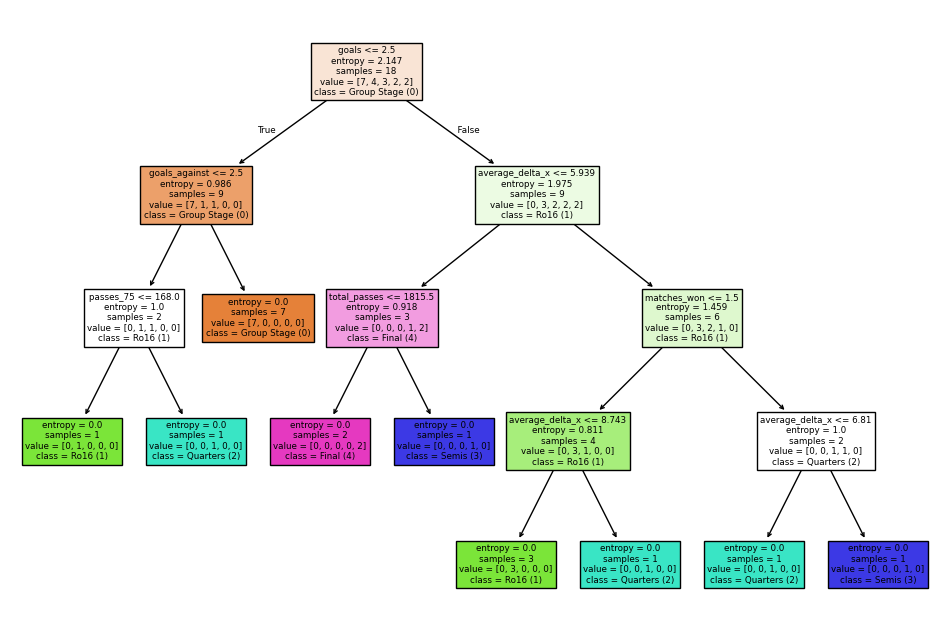

In [7]:
#gathering all relevant input data from our data frame
X = euro_master_df[["rankings", "goals", "goals_against", "matches_won", "passes_75", "average_gs_goals_per_game", "total_passes","average_delta_x"]]

#predicting stage
X_train, X_test, y_train, y_test = train_test_split(X, euro_master_df["advancing"], test_size=0.25, random_state=1)

#creating our three decision trees, each using a different splitting process
stage_prediction_dt_gini = DecisionTreeClassifier(criterion="gini")
stage_prediction_dt_entropy = DecisionTreeClassifier(criterion="entropy")
stage_prediction_dt_log_loss = DecisionTreeClassifier(criterion="log_loss")

stage_prediction_forest = [stage_prediction_dt_gini, stage_prediction_dt_entropy, stage_prediction_dt_log_loss]

#getting summary statistics for all of our trees to compare
print("--STAGE PREDICTION--")
for x in stage_prediction_forest:
  x.fit(X_train,y_train)
  y_pred = x.predict(X_test)
  print(y_pred)
  print(np.array(y_test))
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
  print("F1 Score:",metrics.f1_score(y_test, y_pred, average='weighted'))
  print("\n")

#plot of best performing tree
plt.figure(figsize=(12,8))
tree.plot_tree(stage_prediction_dt_entropy, filled=True, feature_names = X.columns, class_names = ["Group Stage (0)", "Ro16 (1)", "Quarters (2)", "Semis (3)", "Final (4)"])
plt.show()

In [8]:
#getting our training and test splits of data based on what we would like to predict, which is advancement in this case
X_train, X_test, y_train, y_test = train_test_split(X, euro_master_df["advancing"], test_size=0.25, random_state=1)

#creating our random forest classifier object and getting summary statistics
random_forest_advancement_stage = RandomForestClassifier(n_estimators=100)
random_forest_advancement_stage.fit(X_train,y_train)
y_pred = random_forest_advancement_stage.predict(X_test)
print(y_pred)
print(np.array(y_test))
print("--RANDOM FOREST SCORING--")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
print("F1 Score:",metrics.f1_score(y_test, y_pred, average='weighted'))
print("\n")

[2 2 0 3 0 0]
[1 2 1 1 0 1]
--RANDOM FOREST SCORING--
Accuracy: 0.3333333333333333
Precision: 0.13888888888888887
F1 Score: 0.19444444444444442




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


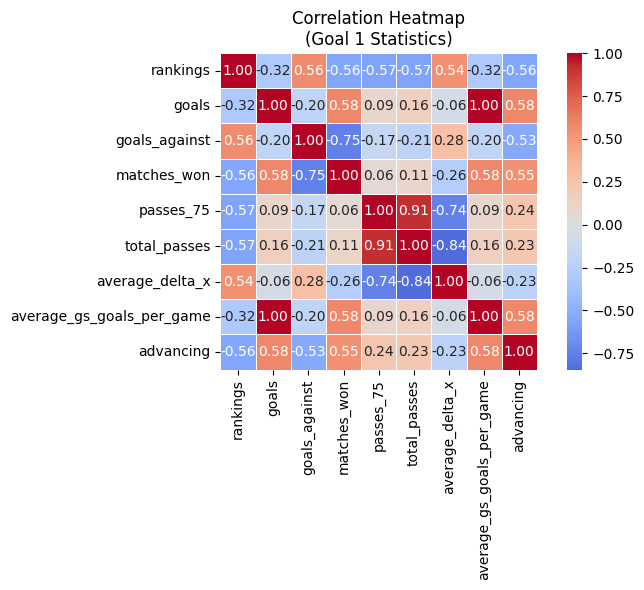

In [9]:
#Correlation Heatmap Analysis
import seaborn as sns

goal1_features = euro_master_df[['rankings', 'goals', 'goals_against', 'matches_won', 'passes_75', 'total_passes', 'average_delta_x', 'average_gs_goals_per_game', 'advancing']]

correlation_matrix = goal1_features.corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, linewidth=0.5)
plt.title('Correlation Heatmap\n(Goal 1 Statistics)')
plt.tight_layout()
plt.show()

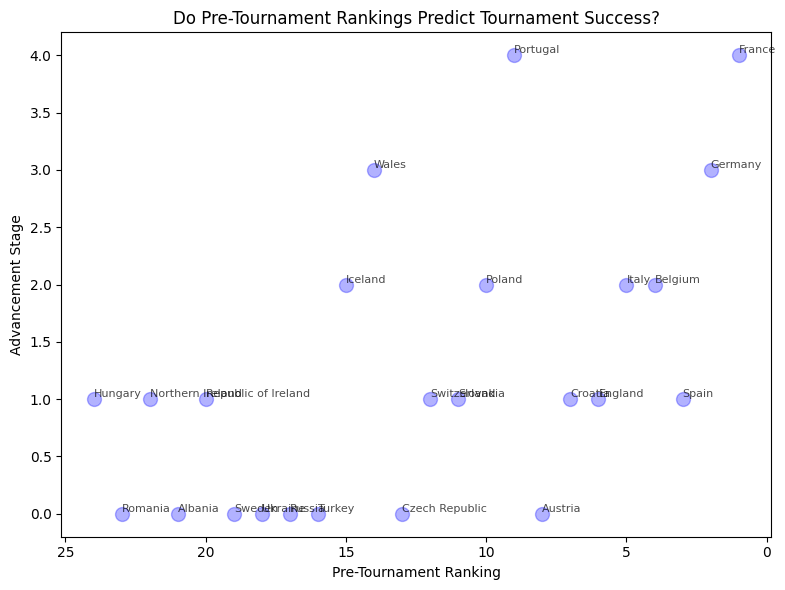

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(euro_master_df['rankings'], euro_master_df['advancing'], color='blue', alpha=0.3, s=100)

for i, team in enumerate(euro_master_df['team_name']):
  plt.annotate(team, (euro_master_df['rankings'].iloc[i], euro_master_df['advancing'].iloc[i]), fontsize=8, alpha=0.7, ha='left', va='bottom')

plt.xlabel('Pre-Tournament Ranking')
plt.ylabel('Advancement Stage')
plt.title('Do Pre-Tournament Rankings Predict Tournament Success?')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

# **Modeling for Goal (2)**

--ENTERTAINMENT PREDICTION--
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
Accuracy: 0.6363636363636364
Precision: 0.6439393939393939
F1 Score: 0.6168831168831169


[0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
[1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
Accuracy: 0.6363636363636364
Precision: 0.6439393939393939
F1 Score: 0.6168831168831169


[0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.]
[1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
Accuracy: 0.5454545454545454
Precision: 0.538961038961039
F1 Score: 0.5376845376845377




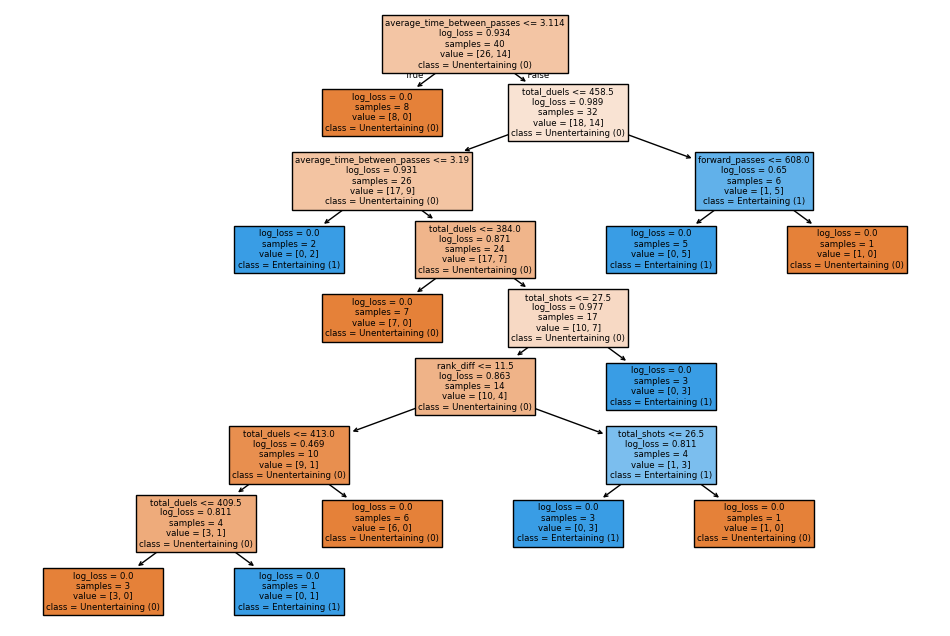

In [11]:
#gathering relevant input data from our data frame to try to classify entertainment value
X = matches_classifier_df[["total_passes", "total_duels", "forward_passes", "rank_diff", "average_time_between_passes", "total_shots", "halftime_entertainment_category"]]

#training and testing data set splits
X_train, X_test, y_train, y_test = train_test_split(X, matches_classifier_df["entertainment_category"], test_size=0.2, random_state=1)

#getting a forest of decision trees, each with a different splitting mechanism
entertainment_prediction_dt_gini = DecisionTreeClassifier(criterion="gini")
entertainment_prediction_dt_entropy = DecisionTreeClassifier(criterion="entropy")
entertainment_prediction_dt_log_loss = DecisionTreeClassifier(criterion="log_loss")

#creation of foreset
entertainment_prediction_forest = [entertainment_prediction_dt_gini, entertainment_prediction_dt_entropy, entertainment_prediction_dt_log_loss]

#getting the entertainment value predictions as well as summary statistics for each tree
print("--ENTERTAINMENT PREDICTION--")
for x in entertainment_prediction_forest:
  x.fit(X_train,y_train)
  y_pred = x.predict(X_test)
  print(y_pred)
  print(np.array(y_test))
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
  print("F1 Score:",metrics.f1_score(y_test, y_pred, average='weighted'))
  print("\n")

#plot of best performing tree
plt.figure(figsize=(12,8))
tree.plot_tree(entertainment_prediction_dt_log_loss, filled=True, feature_names = X.columns, class_names =["Unentertaining (0)","Entertaining (1)"])
plt.show()

In [12]:
#random forest for predicting entertainment value
X = matches_classifier_df[["total_passes", "total_duels", "forward_passes", "rank_diff", "average_time_between_passes", "total_shots", "halftime_entertainment_category"]]

#training and testing split of data
X_train, X_test, y_train, y_test = train_test_split(X, matches_classifier_df["entertainment_category"], test_size=0.2, random_state=1)

#getting results and summary statistics on our random forest classifier
random_forest_entertainment = RandomForestClassifier(n_estimators=100)
random_forest_entertainment.fit(X_train,y_train)
y_pred = random_forest_entertainment.predict(X_test)
print(y_pred)
print(np.array(y_test))
print("--RANDOM FOREST SCORING--")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
print("F1 Score:",metrics.f1_score(y_test, y_pred, average='weighted'))
print("\n")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
--RANDOM FOREST SCORING--
Accuracy: 0.5454545454545454
Precision: 0.29752066115702475
F1 Score: 0.3850267379679144




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                           Feature  Coefficient
4      average_time_between_passes     0.477488
1                      total_duels     0.330797
6  halftime_entertainment_category     0.316318
3                        rank_diff     0.280295
2                   forward_passes     0.064000
5                      total_shots    -0.092804
0                     total_passes    -0.320956


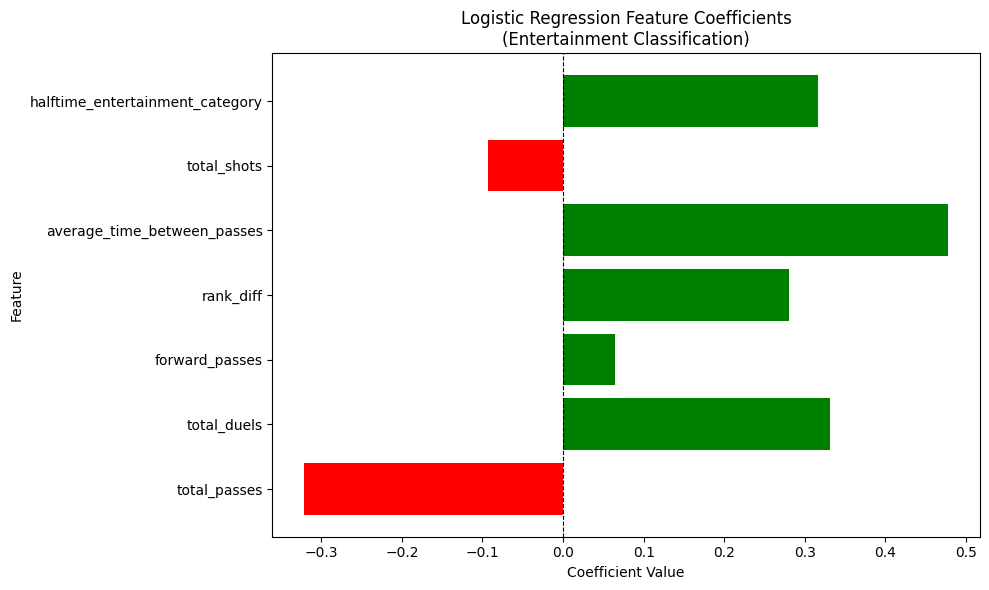

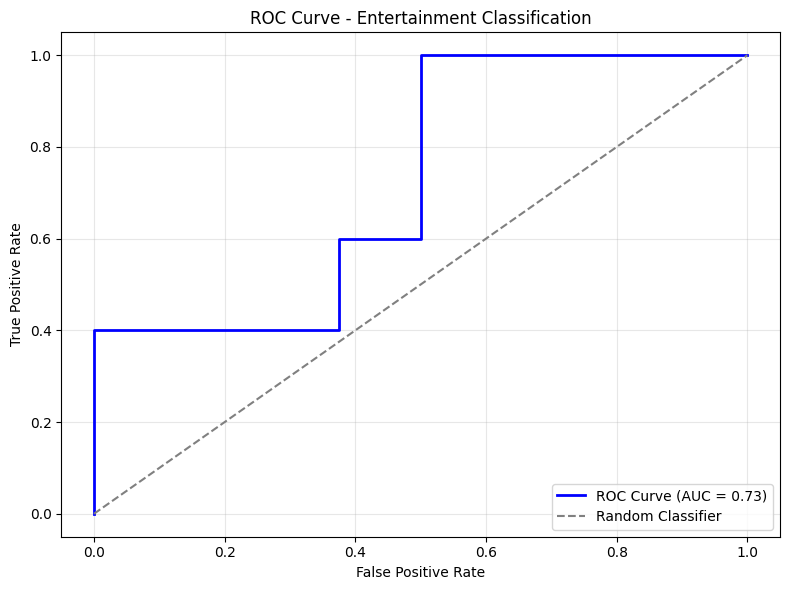

In [13]:
#Goal 2 - Predicting Entertainment via Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

X_entertainment = matches_classifier_df[["total_passes", "total_duels", "forward_passes", "rank_diff", "average_time_between_passes", "total_shots", "halftime_entertainment_category"]]
y_entertainment = matches_classifier_df["entertainment_category"]

#Scale Features
scaler = StandardScaler()
X_ent_scaled = scaler.fit_transform(X_entertainment)

X_ent_train, X_ent_test, y_ent_train, y_ent_test = train_test_split(X_ent_scaled, y_entertainment, test_size=0.25, random_state=1)

#Train the model
log_reg = LogisticRegression()
log_reg.fit(X_ent_train, y_ent_train)
y_pred = log_reg.predict(X_ent_test)

#Check feature importance coefficients
coef_df = pd.DataFrame({'Feature': X_entertainment.columns,
                        'Coefficient': log_reg.coef_[0]})
print(coef_df.sort_values('Coefficient', ascending=False))

#Plot 1 - Feature Coefficient Bar Chart
plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=['red' if c < 0 else 'green' for c in coef_df['Coefficient']])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Coefficients\n(Entertainment Classification)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

#Plot 2 - ROC Curve
y_pred_proba = log_reg.predict_proba(X_ent_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_ent_test, y_pred_proba)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='blue',lw=2,label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Entertainment Classification')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# **Deployment**

# **Goal (1)**

***Decision Tree / Random Forrest Analysis***

For goal (1), we can see that our models underperformed. We can see from our results that our entropy model was the best performing decision tree on this data split which had an accuracy of ~33.3%. The best splits that occured earliest are indicated to be the number of goals scored by a team in the groupstage. In each respective subtree of our model, we can see that goals against and average pass movement were the next most indicative splitting decision. However, as we move into the subtrees, we notice that the entropy of each attribute drops considerably. In addition, we should note the limitation of the data in this tournament as our instances are teams within the tournament making it harder to make a prediction model that accurately predicts the stage reached in the tournament. In addition, we also note that our model is trying to predict *exactly* where a team will get eliminated/the furthest point it will make it into the tournament. The random decision forest performed the same. We would report to UEFA that the number of goals scored in the group stage are most indiciative of a splitting category that differentiates teams that will make it to the quarterfinal stage of the tournament based on our tree structure.

***Statistic Correlation / Pre-Post Tournament Ranking Analysis***

To supplement our decision tree analysis for goal (1), we wanted to visualize the correlations between the various variables through a correlation heatmap matrix. This is helpful because it shows us which variables are most indicative of each other. Although many relationships are revealed, we mainly want to focus on different variables' impact on a team's likelihood of advancing. We see that goals (0.58) and average goals per game (0.58) are most positively correlated with the chance of advancement, and somewhat surprisingly we see that the number of matches won is less correlated with advancement (0.55). We see that rankings are negatively correlated with a team's likelihood of advancement (-0.56) and that goals against are a strong indicator of advancement (-0.53). These results don't yield conclusive causal analyses, but they help us get closer to a definitive casual perspective by helping us define the interactions between data that shape the trends we see. The takeaways from this visualization are the impact of goals for and against on advancement (perhaps a trivial takeaway), but most importantly we see that higher rankings are associated with lower levels of advancement: which indicates that there is a gap between the predictive capability of the models used to make rankings and the reality of the competition space.


# **Goal (2)**

***Decision Tree / Random Forrest Analysis***

For goal (2), we can actually see a model performing well, with the most accurate model performing within ~50% to ~72% accuracy in predicting whether a game will turn out to be entertaining or not. Our random forest model performs similarly to each of our individual trees in terms of accuracy! In the gini index tree structure, we can see a very good split at the beginning when analyzing time between passes and total duels that occured during a match - two indicators of match intensity and flow! In the first few levels of the tree, forward pass, duel, and average time between passes seem to be the most indicative splitting mechanisms/statistics when trying to find whether or not a game will turn out to be entertaining. We would report to UEFA that while our accuracy hovers within the ~50% to ~72% accuracy range, our model tells us that the best indicators of a match being entertaining pertains to a faster flow of the match and a more "physical" match. Rule changes such as a possesion clock (would never happen) or smaller fields (i.e. rules that promote a quicker and more physical match) would likely increase entertainment value of the match itself. Even more interesting, our model does not include any information about whether a match will be entertaining based on its halftime entertainment value! This implies that the halftime entertainment value is not a good indicator of the fulltime entertainment value and may even indicate that the emphasis on the second half may be more indicative of a match's entertainment value.

***Logistic Regression Classification Analysis***

To gain additional perspective beyond our decision tree analyses for goal (2), we decided to run a logistic regression to test different features' impact on the classification of matches as entertaining or not. We created a feature coefficient plot to highlight discrepancies between our features' predictive capabalities. We found average time between passes to be the strongest classifier (0.478) followed by total duels (0.331), halftime entertainment category (0.316), and rank difference (0.280). Surprisingly, we found forward passes (0.064) and total shots (-0.092) to be relatively inconsequential. One key takeaway is that total passes (-0.321) can be indicative of low entertainment value, which tells us that the fans find games with lots of passing boring. Additionally, we created a plot to visualize the ROC Curve (the classification's true positive rate plotted against its false positive rate) for our logistic regression. On such plots a perfect classifier has an area under the curve of 1.0 and a random classifier has an area under the curve of 0.5. We found our regression to have an area under the curve of 0.73, indicating we are better than a random classifier, but only about halfway to perfect. This tells us that our features may not be the most indicative of entertainment value, and that we should expand our scope in future analyses.

# **Resources**


**ESPN Pre-tournament Rankings for UEFA Euros 2016**

https://www.espn.com/soccer/story/_/id/37449564/france-top-euro-2016-power-rankings-germany-second-spain-third

**Dataset Used for Analysis**

https://figshare.com/articles/dataset/Events/7770599?backTo=%2Fcollections%2F_%2F4415000&file=14464685

Pappalardo et al., (2019) A public data set of spatio-temporal match events in soccer competitions, Nature Scientific Data 6:236, https://www.nature.com/articles/s41597-019-0247-7

Pappalardo et al. (2019) PlayeRank: Data-driven Performance Evaluation and

Player Ranking in Soccer via a Machine Learning Approach. ACM Transactions on Intellingent Systems and Technologies (TIST) 10, 5, Article 59 (September 2019), 27 pages. DOI: https://doi.org/10.1145/3343172

**History of UEFA Euro 2016 Matches**

https://www.uefa.com/uefaeuro/history/seasons/2016/matches/

**sklearn API**

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
